In [ ]:
import numpy as np
import pandas as pd
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.metrics import plot_confusion_matrix


# Audio
import librosa.display, librosa

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


**Philharmonic Dataset**

In [ ]:
!wget https://philharmonia-assets.s3-eu-west-1.amazonaws.com/uploads/2020/02/12112005/all-samples.zip
!unzip all-samples.zip
!rm -r all-samples.zip
!unzip all-samples/bassoon.zip 
!unzip all-samples/violin.zip
!unzip all-samples/clarinet.zip
!unzip all-samples/saxophone.zip

**IRMAS Dataset**

In [ ]:
!wget https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip?download=1

--2020-06-04 10:35:51--  https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181049879 (3.0G) [application/octet-stream]
Saving to: ‘IRMAS-TrainingData.zip?download=1’

IRMAS-TrainingData. 100%[===================>]   2.96G  18.3MB/s    in 5m 49s  

2020-06-04 10:41:41 (8.70 MB/s) - ‘IRMAS-TrainingData.zip?download=1’ saved [3181049879/3181049879]



In [ ]:
!unzip IRMAS-TrainingData.zip?download=1

**Extracting required 5 musical instrumnet classes from the dataset**

In [ ]:
classes = ['bassoon','violin','clarinet','saxophone', 'voi']   #only selecting five instrument classes out of all the instrument classes
x_data = {}
for i in os.listdir('./'):
  temp = i.split('_')[0]
  if temp not in classes:
    continue
  if temp not in x_data : 
    x_data[temp] = [i]
  else:
    x_data[temp].append(i)


for i in os.listdir("IRMAS-TrainingData/voi"):
  if 'voi' not in x_data : 
    x_data['voi'] = ["IRMAS-TrainingData/voi/"+i]
  else:
    x_data['voi'].append("IRMAS-TrainingData/voi/"+i)

In [ ]:
x_data['clarinet']

**Parameters for MFCC**

In [ ]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 1024       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13       #13 MFCC coefficients

**Function to Calculate Audio Features: MFCC**

In [ ]:
# Define Function to Calculate MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    return feature_vector

**Load audio files, calculate features and create feature vectors**

In [ ]:
%%time
import tqdm
import multiprocessing
from joblib import Parallel, delayed           #parallel extraction of features from the sample
feature_vectors = []
labels = []
def yourfunction(k): 
    i = k
    k = x_data[k]
    feature_vectors = []
    labels = []
    for j in tqdm.tqdm(k[:720]):   #taking  720 samples from each musical instrument class
      try :
        y, sr = librosa.load(j, sr=fs)
        y/=y.max() #Normalize
        feat = get_features(y, sr)  #extracting mfcc features
        feature_vectors.append(feat)
        labels.append(i)
      except :
        continue
    return np.array(feature_vectors) , labels

element_run = Parallel(n_jobs=5)(delayed(yourfunction)(k) for k in x_data)


CPU times: user 212 ms, sys: 46.8 ms, total: 259 ms
Wall time: 7min 24s


In [ ]:
feature_vectors = np.hstack([ element_run[k][:-1] for k in range(len(element_run))]).reshape(-1,13)
labels =  np.hstack([element_run[k][-1] for k in range(len(element_run))])
feature_vectors.shape,labels.shape

((3599, 13), (3599,))

**Standardization: Zero-Mean and Unit-Variance and Encode Labels**

In [ ]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

Feature vectors shape: (3599, 13)
5 classes: bassoon, clarinet, saxophone, violin, voi


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_feature_vectors, classes_num, test_size=0.25, random_state=42)
# Check Set Shapes
print("train_set shape:",X_train.shape)
print("test_set shape:",X_test.shape)
print("train_classes shape:",y_train.shape)
print("test_classes shape:",y_test.shape)

train_set shape: (2699, 13)
test_set shape: (900, 13)
train_classes shape: (2699,)
test_classes shape: (900,)


**Naive Bayes Classifier**

In [ ]:
#instantiate the  Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(classification_report(y_test , predicted , target_names = ['bassoon', 'clarinet' , 'saxophone' , 'violin', 'voi']))

              precision    recall  f1-score   support

     bassoon       0.83      0.92      0.87       185
    clarinet       0.76      0.69      0.72       183
   saxophone       0.62      0.63      0.63       156
      violin       0.84      0.85      0.84       194
         voi       0.98      0.93      0.96       182

    accuracy                           0.81       900
   macro avg       0.81      0.81      0.80       900
weighted avg       0.81      0.81      0.81       900



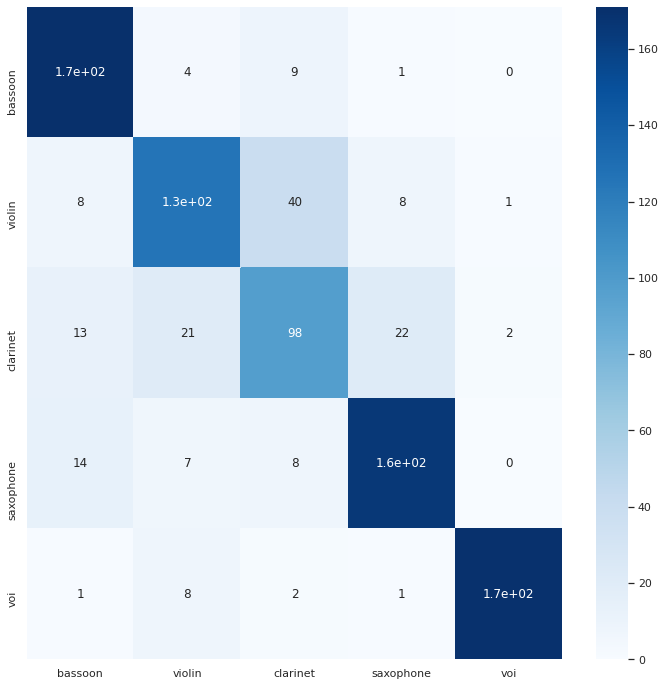

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, predicted)
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(cf_matrix, annot=True , cmap = 'Blues', xticklabels = classes ,yticklabels= classes  )


**Logistic Regression Classifier**

In [ ]:
#Logistic Regression 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(classification_report(y_test , predicted , target_names = ['bassoon', 'clarinet' , 'saxophone' , 'violin','voi']))

              precision    recall  f1-score   support

     bassoon       0.98      0.99      0.99       185
    clarinet       0.93      0.85      0.89       183
   saxophone       0.87      0.91      0.89       156
      violin       0.92      0.96      0.94       194
         voi       0.96      0.95      0.96       182

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



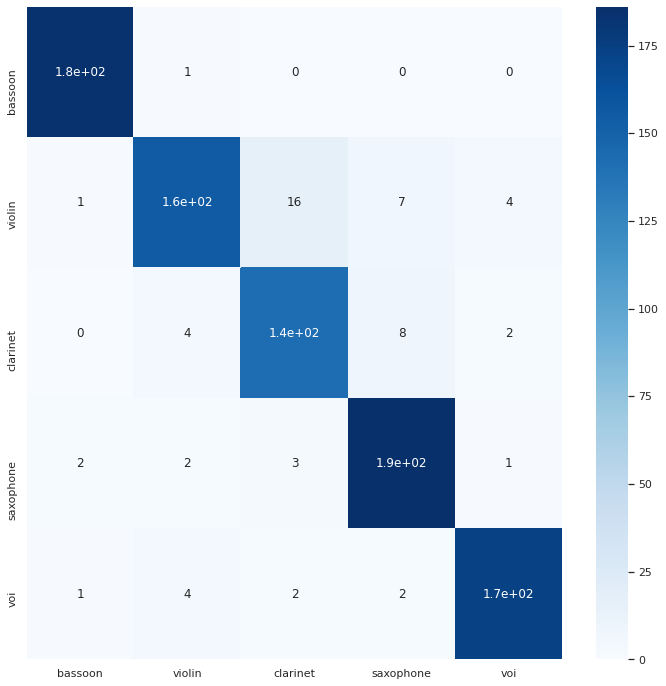

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, predicted)
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(cf_matrix, annot=True , cmap = 'Blues', xticklabels = classes ,yticklabels= classes  )


**SVM with RBF kernel Classifier**

In [ ]:
#svm 
from sklearn.svm import SVC
from sklearn.metrics import classification_report
clf = SVC(gamma='auto' , C= 10 , kernel = 'rbf')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(classification_report(y_test , predicted , target_names = ['bassoon', 'clarinet' , 'saxophone' , 'violin','voi']))

              precision    recall  f1-score   support

     bassoon       1.00      1.00      1.00       185
    clarinet       0.99      0.99      0.99       183
   saxophone       0.97      0.99      0.98       156
      violin       1.00      0.99      1.00       194
         voi       1.00      0.99      1.00       182

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



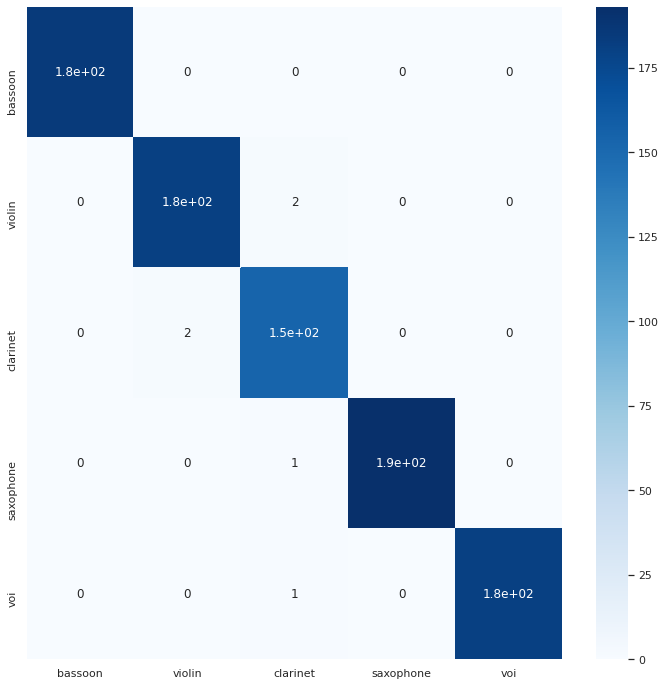

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, predicted)
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(cf_matrix, annot=True , cmap = 'Blues', xticklabels = classes ,yticklabels= classes  )

**Random forest Classifier**

In [ ]:
#random forest 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth= 13 , n_estimators = 100 , random_state=42)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(classification_report(y_test , predicted , target_names = ['bassoon', 'clarinet' , 'saxophone' , 'violin','voi']))

              precision    recall  f1-score   support

     bassoon       1.00      0.99      0.99       185
    clarinet       0.97      0.95      0.96       183
   saxophone       0.92      0.96      0.94       156
      violin       0.97      0.98      0.98       194
         voi       0.99      0.98      0.98       182

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



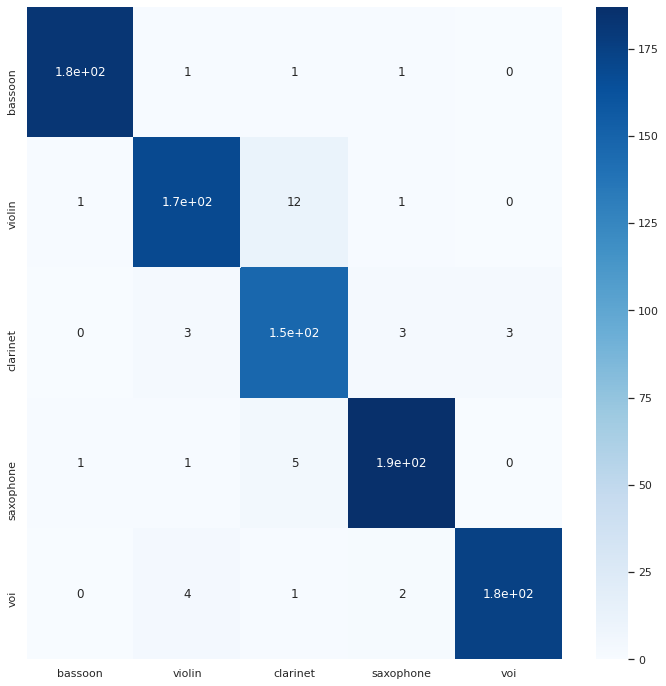

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, predicted)
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(cf_matrix, annot=True , cmap = 'Blues', xticklabels = classes ,yticklabels= classes  )

**KNN Classifier**

In [ ]:
# kNN
n_neighbors=1
clf = KNeighborsClassifier(n_neighbors= 1)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(classification_report(y_test , predicted , target_names = ['bassoon', 'clarinet' , 'saxophone' , 'violin','voi']))

              precision    recall  f1-score   support

     bassoon       0.99      0.99      0.99       185
    clarinet       0.99      0.98      0.98       183
   saxophone       0.96      0.99      0.97       156
      violin       0.99      0.98      0.99       194
         voi       1.00      1.00      1.00       182

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



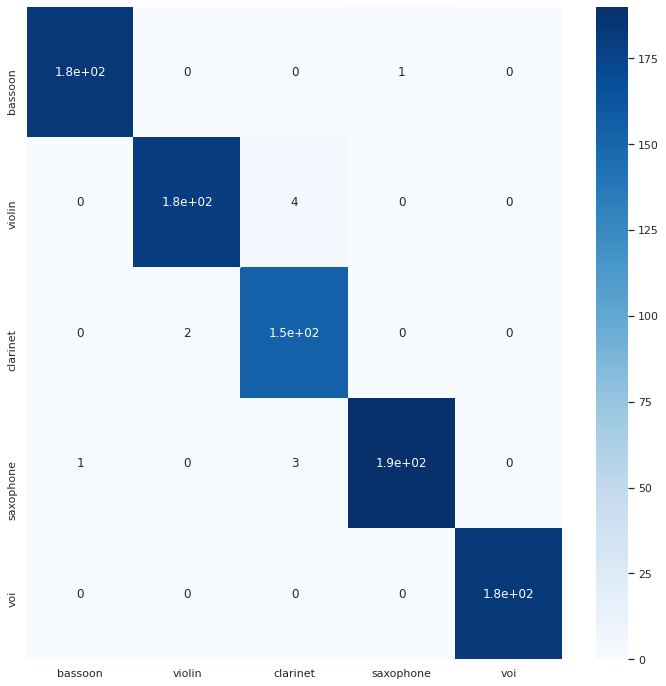

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, predicted)
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(cf_matrix, annot=True , cmap = 'Blues', xticklabels = classes ,yticklabels= classes  )

**Neuralnet Classifier**

In [ ]:
# Deep Learning
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model
# Random Seed
from numpy.random import seed
seed(1)


# DNN
# Use Keras Backend Type
X_train_d = X_train.astype(K.floatx())
X_test_d = X_test.astype(K.floatx())

Using TensorFlow backend.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
# One Hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded_train_classes =  y_train.reshape(len( y_train), 1)
onehot_encoded_train_classes = onehot_encoder.fit_transform(integer_encoded_train_classes,1)
integer_encoded_test_classes =  y_test.reshape(len( y_test),1)
onehot_encoded_test_classes = onehot_encoder.fit_transform(integer_encoded_test_classes,1)

In [ ]:
# Check Set Shapes
print("X_train shape:",X_train_d.shape)
print("X_test shape:",X_test_d.shape)
print("y_train shape:",onehot_encoded_train_classes.shape)
print("y_test shape:",onehot_encoded_test_classes.shape)

X_train shape: (2699, 13)
X_test shape: (900, 13)
y_train shape: (2699, 5)
y_test shape: (900, 5)


**Changing y values into onehot vector form**

In [ ]:
# Reshape Sets for Keras
X_train_d=X_train.reshape(X_train_d.shape[0],1,X_train_d.shape[1])
X_test_d=X_test.reshape(X_test_d.shape[0],1,X_test_d.shape[1])
y_train_d_hot=onehot_encoded_train_classes.reshape(onehot_encoded_train_classes.shape[0],1,
                                                         onehot_encoded_train_classes.shape[1])
y_test_d_hot=onehot_encoded_test_classes.reshape(onehot_encoded_test_classes.shape[0],1,
                                                       onehot_encoded_test_classes.shape[1])

**Creating Simple model with 2 Dense layes**

In [ ]:
# Creat Simple Model
import keras.backend as K 
K.clear_session()
model_input = Input(shape=(1,X_train.shape[1]))
fc1 = Dense(640, activation="relu")(model_input)
fc2 = Dense(64, activation="relu")(fc1)
#fc3 = Dense(8, activation="relu")(fc2)
n=onehot_encoded_train_classes.shape[1]
out = Dense(n, activation="softmax")(fc2)
model_d = Model(inputs=[model_input], outputs=[out])
model_d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 13)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 640)            8960      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 64)             41024     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 5)              325       
Total params: 50,309
Trainable params: 50,309
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile Model
model_d.compile(loss = 'categorical_crossentropy',   #loss function
              optimizer = 'SGD',  #SGD is stochastic gradient descent optimizer
              metrics   =['accuracy'])

In [ ]:
# Deep Learning Parameters
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import model_from_json

batch_size = 32 # Number of samples per gradient update.
epochs = 50  # An epoch is an iteration over the entire x and y data provided.

filepath="model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Train Model
hist = model_d.fit(X_train_d, y_train_d_hot, verbose=1, 
                    batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks_list)

Train on 2159 samples, validate on 540 samples
Epoch 1/50
2159/2159 [==============================] - 1s 233us/step - loss: 1.3868 - accuracy: 0.6429 - val_loss: 1.2017 - val_accuracy: 0.7796

Epoch 00001: accuracy improved from -inf to 0.64289, saving model to model.h5
Epoch 2/50
2159/2159 [==============================] - 0s 64us/step - loss: 1.0756 - accuracy: 0.7902 - val_loss: 0.9351 - val_accuracy: 0.8148

Epoch 00002: accuracy improved from 0.64289 to 0.79018, saving model to model.h5
Epoch 3/50
2159/2159 [==============================] - 0s 59us/step - loss: 0.8499 - accuracy: 0.8346 - val_loss: 0.7535 - val_accuracy: 0.8426

Epoch 00003: accuracy improved from 0.79018 to 0.83465, saving model to model.h5
Epoch 4/50
2159/2159 [==============================] - 0s 60us/step - loss: 0.6921 - accuracy: 0.8550 - val_loss: 0.6279 - val_accuracy: 0.8556

Epoch 00004: accuracy improved from 0.83465 to 0.85503, saving model to model.h5
Epoch 5/50
2159/2159 [=========================

In [ ]:
# serialize model to JSON
model_json = model_d.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_d.save_weights("model.h5")
print("Saved model to disk")

# later...

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_d = model_from_json(loaded_model_json)
# load weights into new model
model_d.load_weights("model.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


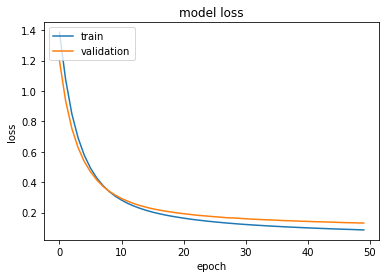

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in hist
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
 # Printing Classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
x_pred = model_d.predict(X_test_d)
# x_pred = np.round(x_pred)
x_pred = x_pred.argmax(axis=2)
print(classification_report(y_test, x_pred ,target_names = ['bassoon', 'clarinet' , 'saxophone' , 'violin','voi']))

              precision    recall  f1-score   support

     bassoon       0.98      0.99      0.99       185
    clarinet       0.95      0.93      0.94       183
   saxophone       0.92      0.97      0.95       156
      violin       0.99      0.98      0.98       194
         voi       0.98      0.95      0.96       182

    accuracy                           0.97       900
   macro avg       0.96      0.97      0.96       900
weighted avg       0.97      0.97      0.97       900



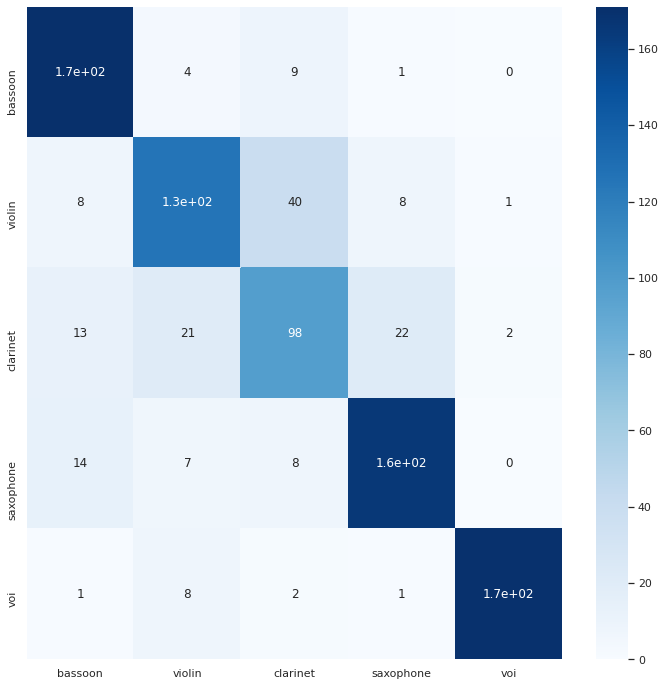

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, predicted)
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(cf_matrix, annot=True , cmap = 'Blues', xticklabels = classes ,yticklabels= classes  )